# **Whole slide segmentation of CellDIVE multiplex images using `DeepCell`**

Run through this notebook step-by-step and adjust the code if necessary at any point in the process. The explaination and comments througout the notebook will help and guide through the proces. There will also be pointers as to what modification to a particular you might want to consider.

The structure of this notebook is adapted from and consequently loosely follows the structure and logic of the segmentation notebook of the `ark-analysis` toolset. Thus, it makes use some of the `ark-analysis` tooling as well

## Dependencies
We load all the necessary libraries used for the segmentation, viusalisation and quantification in this notebook.

In [18]:
# import required packages
import os
import warnings
from pathlib import Path
import pathlib
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as io
import xarray as xr
from alpineer import io_utils, load_utils, image_utils

from ark.segmentation import marker_quantification, segmentation_utils
from ark.utils import (deepcell_service_utils, plot_utils)

from tensorflow.keras.models import load_model
from deepcell.applications import Mesmer
from deepcell.utils.plot_utils import make_outline_overlay
from deepcell.utils.plot_utils import create_rgb_image

from wsi_segmentation.segmentation_utils import predict_tiled
from wsi_segmentation.io_utils import save_model_output_wrapper

from tqdm.notebook import tqdm
from ipyfilechooser import FileChooser

## 1. Define data location and setup directory structure

### 1.1 Set data directory

The first step is to set the *data/base directory* `base_dir` that contains a folder called `ome_tiff` with 1 *ome.tiff* per slide. The content of the *base* directory would look something like example below. We will also save the results and all the pipeline outputs in this folder as well.

```
└── ome_tiff
    ├── slide_asdfghjk.ome.tiff
    └── slide_qwertyui.ome.tiff
    
```

In order to define the *data/base directory* we have two options:
* set `use_filechooser=True` and use the widget to find and identify the data/base directory
* set `use_filechooser=False` and manual define the data/base directory below via `data_dir=`

**NOTE: In `WSL` the `C:` drive, `D:` drive, etc are mounted and located at `/mnt/c`, `/mnt/d`, etc, respectively.**

In [19]:
use_filechooser = True

In [20]:
if use_filechooser:
    fc = FileChooser("")
    fc.show_only_dirs = True
    fc.title = '<b>Choose data folder that contains `ome_tiff` folder with 1 ome_tiff per slide</b>'
    display(fc)
else:
    data_dir = "/path/to/data/directory"

FileChooser(path='/home/jonas/OneDrive/shared_work/03_software_projects/02_KIR-CellDIVE/wsi-segmentation/noteb…

In [4]:
# set the base directory
base_dir = fc.selected_path if use_filechooser == True else data_dir

### 1.2 Setup intermediate and results paths

Next, we create all the required output and results directories such that we have the following folder structure in the `base directory`:

```
├── ome_tiff
├── image_data
└── segmentation
    ├── cell_table
    ├── cell_table_raw
    ├── deepcell_input
    ├── deepcell_output
    └── deepcell_visualization
    
```

Here, we set all the directory names to be created.

In [5]:
ome_tiff_dir = os.path.join(base_dir, "ome_tiff")
tiff_dir = os.path.join(base_dir, "image_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table_raw")
cell_table_dir_qc = os.path.join(base_dir, "segmentation/cell_table")
deepcell_input_dir = os.path.join(base_dir, "segmentation/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/deepcell_output")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/deepcell_visualization")

Then, we check if the directoies exist and if not create them.

In [6]:
for directory in [tiff_dir, cell_table_dir, cell_table_dir_qc, deepcell_input_dir, deepcell_output_dir, deepcell_visualization_dir ]:
    if not os.path.exists(directory):
        os.makedirs(directory)

Finally, validate that all the directories have been created correctly, so we can proceed with the rest of the notebook.

In [7]:
# validate paths
io_utils.validate_paths([base_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         cell_table_dir,
                         cell_table_dir_qc,
                         deepcell_visualization_dir
])

## 2. Data preprocessing

### 2.1 Split OME TIFF files into single-channel TIFFs

Assuming we have obtained multichannel `ome.tiff` files from the CellDIVE platform, we have to split them into single channel `tiff` files. To achieve this, set `split_ome = True` and split the `ome.tiff` by running the below steps. If you have run this step previously and already split up the `ome.tiff` files you can set `split_ome = False` to skip this step.

Alternatively, you can also manually create one folder per image/slide containing single channel `tiff`s inside the `image_data` folder in the `base/data folder`.

In [8]:
split_ome = True

In [9]:
if split_ome:
    # Gather all the OME-TIFFs
    ome_dir = pathlib.Path(ome_tiff_dir)
    ome_tiffs = list(ome_dir.glob("*.ome.[tif tiff]*"))

    os.listdir(ome_tiff_dir)

In [10]:
# # Convert all the OME-TIFFs to Single Channel TIFFs
if split_ome:
    for ome_tiff in tqdm(ome_tiffs):
        load_utils.ome_to_fov(ome_tiff, data_dir=tiff_dir)

  0%|          | 0/2 [00:00<?, ?it/s]

After these steps we should have one directory per slide in the `image_data` directory containing single `.tiff` files per channel. Looking similiar to this:

```
├── ome_tiff
│   ├── slide_asdfghjk.ome.tiff
│   └── slide_qwertyui.ome.tiff
└── image_data
    ├── slide_asdfghjk
    │   ├── ChannelNameA.tiff
    │   ├── ChannelNameB.tiff
    │   ├── ChannelNameC.tiff
    │   ├── ChannelNameD.tiff
    │   ├── ChannelNameE.tiff
    │   ├── ChannelNameF.tiff
    │   ├── ChannelNameG.tiff
    │   ├── ChannelNameH.tiff
    │   ├── ChannelNameI.tiff
    │   ├── ChannelNameJ.tiff
    │   ├── ChannelNameK.tiff
    │   ├── .
    │   ├── .
    │   └── .
    └── slide_qwertyui
        ├── ChannelNameA.tiff
        ├── ChannelNameB.tiff
        ├── ChannelNameC.tiff
        ├── ChannelNameD.tiff
        ├── ChannelNameE.tiff
        ├── ChannelNameF.tiff
        ├── ChannelNameG.tiff
        ├── ChannelNameH.tiff
        ├── ChannelNameI.tiff
        ├── ChannelNameJ.tiff
        ├── ChannelNameK.tiff
        ├── .
        ├── .
        └── .
        
```

### 2.2 Filter slides

We might not want to perform the segmentation and analysis on all the slides/images. If that is the case you can adjust and filter for the subset of slides you want to analyse below.

In [11]:
# get all fovs in the folder...
wsis = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually by name
# wsis = np.asarray(fovs)[np.isin(wsis, ["fov10"])]
print(wsis)

We can also list all the channel of the first slide:

In [13]:
io_utils.remove_file_extensions(io_utils.list_files(os.path.join(tiff_dir, wsis[0])))

['CXCR3',
 'PD1',
 'TIGIT',
 'CD38',
 'CD4',
 'CD68',
 'MPO',
 'PDPN',
 'RORGT',
 'TRYPTASE',
 'CD11C',
 'CD20',
 'THY1',
 'CD40L',
 'FAP',
 'DAPI_FINAL',
 'CK8',
 'CCR6',
 'CD45',
 'DAPI_INIT',
 'CCR7',
 'PDGFRA',
 'CD31',
 'CD208',
 'CD40',
 'VIM',
 'IGG',
 'IL1B',
 'CCL19',
 'HLAA',
 'IL23P19',
 'IGD',
 'CXCR5',
 'IGA',
 'FOXP3',
 'CD66B',
 'CTLA4',
 'C1Q',
 'HLADR',
 'CD3',
 'MCAM',
 'CD8A']

### 2.3 Perform hard thresholding for some of the channels

**!! NOTE: You could perform hard thresholding at this point by modifying the single channel images before creating composite channels for segmentation in the next step. !!**

In [17]:
### you can manual implement hard thresholding of selected channel here and overwrite the respective single channel tiffs in the image_data subfolders with the thresholded image.

### 2.4 Load images and compute composite nuclear and membrane channels and save as `Mesmer` compatable input

Next, we define the the *nuclear* `nuc` and *membrane* `mems` channels that will be used as input for the segmentation. Multiple *membrane* or *nuclear* channels will be collapsed into a singular channel, respectively. This can be useful if there is not a singular marker that is ubiquitously expressed by all cells in the tissue in question. At least one of `nucs` and `mems` can not be `None`.

In [14]:
# nuclear channel name(s) (or nucs = None)
nucs = ['DAPI_FINAL']

# # membrane channel name(s) (or mems = None)
# mems = ['HLAA', 'HLADR', 'CD68', 'CK8', 'CD3', 'CD45', 'VIM']
mems = []

Once we have defined the `nuclear` and `membrane` markers, we create the composite nuclear-membrane `tiff` files which will used as the input to the `Deepcell` segmentation model.

In [ ]:
# generate and save deepcell input tiffs
# set img_sub_folder param to None if the image files in tiff_dir are not in a separate sub folder 
deepcell_service_utils.generate_deepcell_input(
    deepcell_input_dir,
    tiff_dir,
    nucs,
    mems,
    wsis,
    img_sub_folder=None
)

Following this step, we have creates a single `tiff` file per slide inside the `segmentation/deepcell_input` folder. This should looks similar to this:

```
└── segmentation
    └──  deepcell_input
        ├── slide_asdfghjk.tiff
        └── slide_qwertyui.tiff
```

## 3. Whole Slide Segmentation via `Deepcell`'s `Mesmer` model

We use the the pre-trained `Mesmer` `MultiplexSegmentation` model provided by the `Deepcell` library. `Mesmer` was trained on 20X resolution data and thus depending on the our data we have to rescale the image by setting the `rescale_factor`, such that for 10X image `rescale_factor=2.0` or for a 60X image `rescale_factor=0.33`.

In [16]:
rescale_factor = 1.0

### 3.1 Load `Mesmer` segmentation model

Let's load the pre-trained `Mesmer` model from the hardrive or redownload by setting `keras_model`to `keras_model = None`. 

**!! NOTE: Ignore NUMA node warnings. These warnings are docker/singularity container specific and can be safely ignored. !!**

In [17]:
# set keras_model = None to redownload the latest MultiplexSegmentation
keras_model = load_model(Path("/.keras/models/MultiplexSegmentation") )
app = Mesmer() if keras_model == None else Mesmer(model=keras_model)

2023-08-03 16:20:54.552052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 16:20:54.568437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 16:20:54.570087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-03 16:20:54.573311: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the app

### 3.2 Run segmentation

A final check and chance to adjust and filter the slides on which we will perform the cell segmentation on.

In [36]:
slide_names = io_utils.list_files(os.path.join(deepcell_input_dir))
slide_names

The segmentation function `predicted_tiled` takes various arguments that can/should be adapted for a given experiment:
* overlap:
* cutoff:
* background_threshold:
* infer_gaps:
* compartment:
* pre_processing:
* post_processing:

In [44]:
for slide_name in tqdm(slide_names):
    slide = load_utils.load_imgs_from_dir(deepcell_input_dir, files = [slide_name], xr_channel_names=["nuclear", "membran"])
    segmentation_mask = predict_tiled(slide, overlap=200, cutoff=2, background_threshold= 0.1, max_tile_area = pow(5000,2), infer_gaps=True, compartment="whole-cell", app=app)
    save_model_output_wrapper(segmentation_mask, output_dir=deepcell_output_dir, feature_name=io_utils.remove_file_extensions([slide_name])[0],compartment="whole-cell")

The tile size chosen is: 4484px X 2651px
The overlap is: 200px
Saved 1 frames to /home/ubuntu/data/dataset_1/segmentation/deepcell_output
The tile size chosen is: 4484px X 2651px
The overlap is: 200px
Saved 1 frames to /home/ubuntu/data/dataset_1/segmentation/deepcell_output


## 4. Visualisation

### 4.1 Visualise the segmented mask overlaid on the nuclear and membrane channels used for the segmentation 

To check the results of the segmentation, we can visualise the segmentation mask overlayed on the *nuclear* and *membrane* channel used for the segmentation. You can adjust the `id_to_visualise` variable below to plot result of a different slide.

In [48]:
# create rgb overlay of image data for visualization
id_to_visualise = 0
segmentation_channels = load_utils.load_imgs_from_dir(deepcell_input_dir, files = [io_utils.list_files(os.path.join(deepcell_input_dir))[id_to_visualise]], xr_channel_names=["nuclear", "membran"])
segmentation_mask = load_utils.load_imgs_from_dir(deepcell_output_dir, files = [io_utils.list_files(os.path.join(deepcell_output_dir))[id_to_visualise]])
rgb_images = create_rgb_image(np.asarray(segmentation_channels[:,:,:,:]), channel_colors=['green', 'blue'])
overlay_segmentation = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_mask)

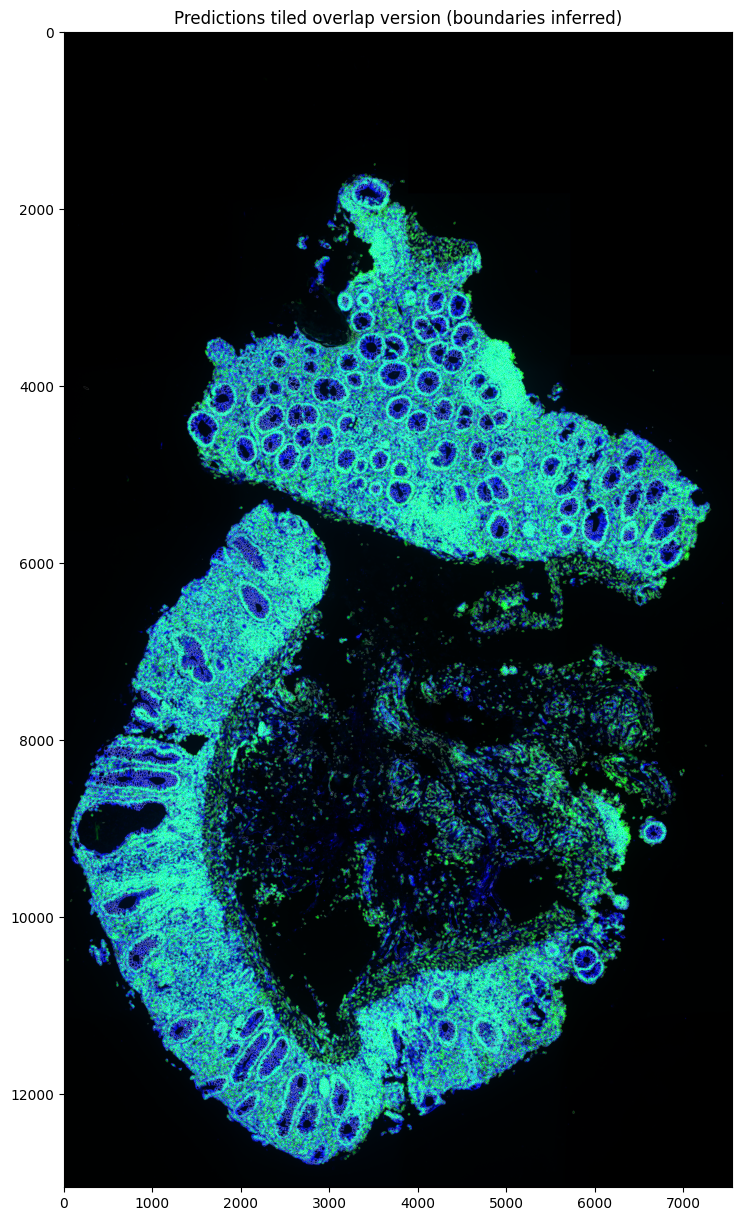

In [49]:
# select index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1 ,figsize=(15, 15))
ax.imshow(overlay_segmentation[idx, ...])
ax.set_title('Predictions tiled overlap version (boundaries inferred)')

plt.show()

### 4.2 Save and visualise all segmentation outputs

Now, we save all the segmentation mask overlay for each slide in the `segmentation/visualisation` directory. You can also visualise a given channel on top of the segmentation by defining the `channel=` argument below with a list `[]` of channel names.

In [50]:
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(wsis),
    channels=None
)

## 5. Quantification and Quality Control

### 5.1 Feature extraction and quantification

In this step we will perform feature extraction and quantification. For a full list of the features extracted, you can refer to the cell table section of at the `ark-analysis` [documentation](https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types). Set the `nuclear_counts` and `fast_extraction` variables below to determine the level of information per cell that is being extracted and calculated. We generate both a size-normalised as well as a `arcsinh` transformed expression matrix for the segmented cells.

In [51]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = False

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = True

In [52]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=wsis,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)

extracting data from ATAPOX166R-3
extracting data from ATAPOX166R-4


We can now save the size-normalised and `arcsinh` transformed expression matrices as `csv` files to hardrive. The compression of these `csv` files can optionally be set via `compression = `

In [53]:
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)

### 5.2 Perform CellDIVE specific QC (DAPI staining deviation and cell size)

Additionally, we perform basic quality control to improve the quality of the data and account for CellDive specific issues such as the loss of cells over multiple rounds of staining (large deviation of DAPI staining between first staining round and final staining round).

In particular we perform two QC steps:
* remove any cell that is smaller than 50 pixel in area
* remove any cell for which the first and last DAPI staining shows a deviation > 0.5 

In [54]:
cell_table_size_normalized_qc = cell_table_size_normalized.loc[cell_table_size_normalized["cell_size"] > 50,]
cell_table_size_normalized_qc = cell_table_size_normalized_qc.loc[abs(cell_table_size_normalized_qc["DAPI_INIT"] - cell_table_size_normalized_qc["DAPI_FINAL"])/cell_table_size_normalized_qc["DAPI_INIT"] <= 0.5, ]

In [55]:
list_arcsinh_transformed_qc = []

for j in wsis:
    array_mask = np.isin(np.array(cell_table_arcsinh_transformed.loc[cell_table_arcsinh_transformed["fov"] == j, "label"]),  np.array(cell_table_size_normalized_qc.loc[cell_table_size_normalized_qc["fov"] == j, "label"]))
    
    df = pd.DataFrame.copy(cell_table_arcsinh_transformed)
    df = pd.DataFrame(df.loc[df["fov"] == j,].loc[array_mask,])
    list_arcsinh_transformed_qc.append(df,) 

cell_table_arcsinh_transformed_qc = pd.concat(list_arcsinh_transformed_qc)

We perform a quick sanity check that both the normalised and transformed data after QC still contain the same cell IDs.

In [56]:
all(cell_table_arcsinh_transformed_qc["label"] == cell_table_size_normalized_qc["label"])

True

We save the cleaned expression matrices as `csv` files to hardrive. The compression of these files can optionally be set via `compression=`.

In [57]:
compression = None
cell_table_size_normalized_qc.to_csv(os.path.join(cell_table_dir_qc, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed_qc.to_csv(os.path.join(cell_table_dir_qc, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)

At this point, we should have something that resembles the following folder structure and files. This folder/data structure should be readibly usable with the `ark-analysis` [pipeline](https://ark-analysis.readthedocs.io/en/latest/) notebooks starting from [Pixel clustering with Pixie](https://github.com/angelolab/ark-analysis#2-pixel-clustering-with-pixie) notebook.

```markdown
└── segmentation
    ├── cell_table
    │   ├── cell_table_arcsinh_transformed.csv
    │   └── cell_table_size_normalized.csv
    ├── cell_table_raw
    │   ├── cell_table_arcsinh_transformed.csv
    │   └── cell_table_size_normalized.csv
    ├── deepcell_input
    │   ├── slide_asdfghjk.tiff
    │   └── slide_qwertyui.tiff
    ├── deepcell_output
    │   ├── slide_asdfghjk_whole_cell.tiff
    │   └── slide_qwertyui_whole_cell.tiff
    └── deepcell_visualization
        ├── slide_asdfghjk_segmentation_borders.tiff
        └── slide_qwertyui_segmentation_borders.tiff
```

## 6. Create output that can be used in other pipelines

This section will provide code to transform/translate the above segmentation result into different formats and structure so they can be used with other existing analysis pipeline. You can also use it to define your own transformation/restructuring function. 

In [9]:
spooxs_output = False

In [10]:
other_output = False

### 6.1 Spooxs

In [16]:
if spooxs_output:
    print("To be implemented.")

### 6.2 Others

In [15]:
if other_output:
    print("To be implemented.")